# подготовка данных и проверка на выбросы

In [171]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# изначально данные это train и test но я их склеил
pd.set_option('display.max_columns',None)

train_path='C:\\Users\\gimaevra94\\Documents\\local\\ab_project\\train.csv'
test_path='C:\\Users\\gimaevra94\\Documents\\local\\ab_project\\test.csv'

train=pd.read_csv(train_path)
test=pd.read_csv(test_path)

data=pd.concat([train,test],axis=0)

data.rename(columns={'Conversion (Target)':'conversion'},inplace=True)
data.rename(columns={'SocialMediaEngagement':'sme'},inplace=True)

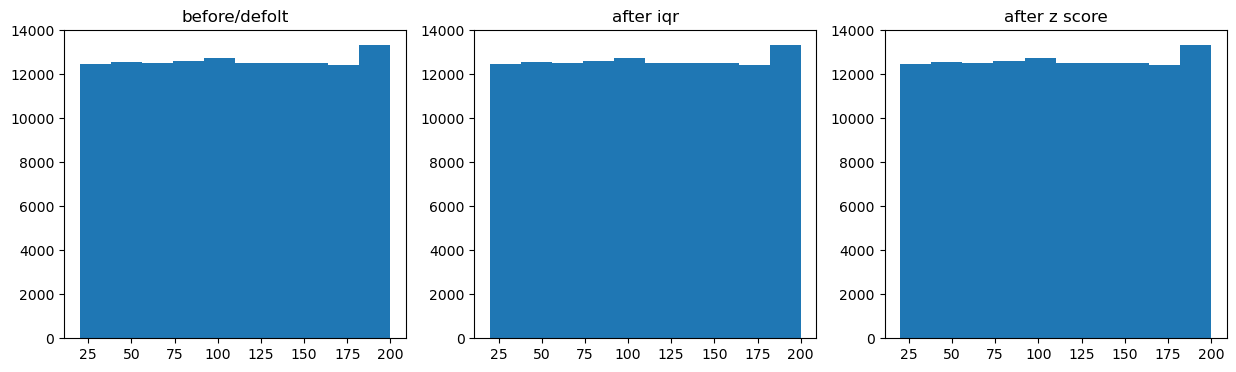

In [172]:
# выборка для проверки выбросов
sme=data[['sme']]

# проверка выбросов с помощью межквартильного размаха
q1=sme.quantile(.25)
q3=sme.quantile(.75)
iqr = q3 - q1

low=q1-1.5*iqr
hight=q3+1.5*iqr
iqr=sme[~((sme<low)|(sme>hight)).any(axis=1)]

# проверка выбросов с помощью z значения
z=np.abs(scipy.stats.zscore(sme))
z_score=sme[(z<3).all(axis=1)]

# вообще никакой разницы по этому оставим данные как есть
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].hist(sme)
axs[0].set_title('before/defolt')

axs[1].hist(iqr)
axs[1].set_title('after iqr')

axs[2].hist(z_score)
axs[2].set_title('after z score')

plt.show()

In [173]:
# делю данные на две группы по 50 квантилю фичи отвечающей за степень активности в социальных сетях
quantile_50=np.quantile(data.sme,.5)

low_sme=data[data['sme']<=quantile_50]
hight_sme=data[data['sme']>quantile_50]

# размер выборки
z=1.96 # взял из таблицы z значений
p=data.conversion.value_counts()[1]/len(data)
e=np.sqrt(p*(1-p)/len(data))*z # взял из какого то ресурса где приводятся формулы для расчета выборки
n=z**2*p*(1-p)/e**2

# из данных разделенных на 2 группы по 50 квантилю семплирую столько данных сколько посчитала формула
a=low_sme.sample(int(n),replace=True)
b=hight_sme.sample(int(n),replace=True)

# отсюда будут браться выборки при повторном отборе
data=pd.concat([a,b],axis=0)

# аб тест

In [174]:
# нулевая гипотеза: статистической значимости не наблюдается
# направленная левосторонняя гипотеза: sme<50 квантиля делают conversion больше чем sme>50 квантиля
# направленная правосторонняя гипотеза: sme<50 квантиля делают conversion меньше чем sme>50 квантиля

# беру общее количество конверсий из переменной 
# в которой склеены две выборки семплированные из изначальных выборок 
# разделенных по 50 квантилю 
# отсюда будут браться выборки при повторном отборе
general_convs=data[['conversion']].reset_index()
general_convs.drop(columns=['index'],inplace=True)

# сразу посчитанная разница между двумя выборками. нужно для повторного отбора
a_b_diffs=list()

# две выборки отдельно. нужно для проверки правосторонней гипотезы
a_diffs=list()
b_diffs=list()

for _ in range(1000):
    # перемешиваю
    general=general_convs.sample(252290)
    
    # беру выборки а и б
    var_a=100 * general.iloc[:126145].mean()
    var_b=100 * general.iloc[126145:].mean()
    
    # считаю разницы
    a_b_diffs.append(var_b - var_a)
    
    # записываю доли для проверки правосторонней гипотезы
    a_diffs.append(var_a)
    b_diffs.append(var_b)
    
# избавляюсь от указаний типа данных
a_b_diffs=[a_b_diffs[i][0] for i,_ in enumerate(a_b_diffs)]
a_diffs=[a_diffs[i][0] for i,_ in enumerate(a_diffs)]
b_diffs=[b_diffs[i][0] for i,_ in enumerate(b_diffs)]

# изначальная разница
initial_diff=np.abs(100*(a.conversion.mean() - b.conversion.mean()))

# доля раз когда семплированные разницы больше наблюдаемой
# так называемое р значение
print('p value перестановочный тест',np.mean([diff > initial_diff for diff in a_b_diffs]) )

# беру размеры выборок и количество конверсий в каждой выборке для стат.тестов
a_len=a.conversion.value_counts()[0]
a_convs=a.conversion.value_counts()[1]

b_len=b.conversion.value_counts()[0]
b_convs=b.conversion.value_counts()[1]

# статистические тесты для проверки корректности реазилации перестановочного теста
survivors = np.array([[a_convs, a_len - a_convs], [b_convs, b_len - b_convs]])
chi2, p_value, df, _ = scipy.stats.chi2_contingency(survivors)
print(f'p value хи квадрат {p_value / 2:.3f}')

_,pvalue=scipy.stats.poisson_means_test(a_convs,a_len,b_convs,b_len)
print(f'p value пуассон {pvalue / 2:.3f}')

# сравнение долей двух групп после перестановочного теста
initial_diff=a.conversion.mean()<b.conversion.mean()
result_diff=np.mean(a_diffs)<np.mean(b_diffs)

print()
print('если p value ниже 0.05 уровня альфы то:')
print('предполагалось: sme<50 квантиля делают conversion меньше чем sme>50 квантиля -',initial_diff)
print('оказалось: sme<50 квантиля делают conversion меньше чем sme>50 квантиля -',result_diff)

p value перестановочный тест 0.336
p value хи квадрат 0.351
p value пуассон 0.346

если p value ниже 0.05 уровня альфы то:
предполагалось: sme<50 квантиля делают conversion меньше чем sme>50 квантиля - True
оказалось: sme<50 квантиля делают conversion меньше чем sme>50 квантиля - False


initial_diff (red) 0.020%
result_diff (green) 0.004%
diff between them 0.016%


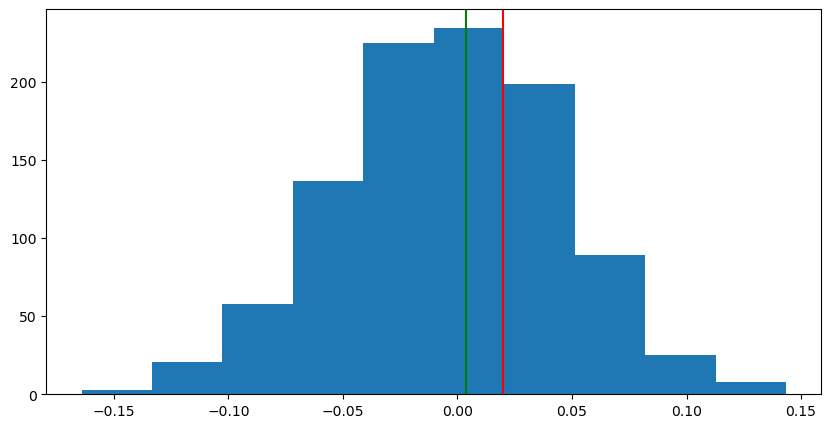

In [175]:
# для полноты картины взглянем как разницы выглядят на гистограмме
initial_line=np.abs(100*(np.abs(a.conversion.mean()-b.conversion.mean())))
result_line=np.abs(np.abs(np.mean(a_diffs)-np.mean(b_diffs)))

plt.figure(figsize=(10,5))
plt.hist(a_b_diffs)
plt.axvline(initial_line, color='r')
plt.axvline(result_line, color='g')

print(f'initial_diff (red) {initial_line:.3f}%')
print(f'result_diff (green) {result_line:.3f}%')
print(f'diff between them {np.abs(round(initial_line-result_line,3))}%')